This is an example to illustrate how fake weak lensing measurements can be generated, 
which can later be used for lens inversion tests

In [1]:
%matplotlib inline
import grale.plotutil as plotutil
import grale.feedback as feedback
import grale.renderers as renderers
import grale.cosmology as cosmology
import grale.lenses as lenses
import grale.images as images
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt

renderers.setDefaultLensPlaneRenderer("threads")
renderers.setDefaultMassRenderer("threads")
feedback.setDefaultFeedback("notebook")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)

cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
cosmology.setDefaultCosmology(cosm)

V = lambda x,y: np.array([x,y], dtype=np.double)

In [2]:
# Load the lens from https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.3253L/abstract
lens = lenses.GravitationalLens.load("threepeaks_wide.lensdata")
zd = 0.4
zs_1 = 1

weakSize = 30*ANGLE_ARCMIN
strongSize = 300*ANGLE_ARCSEC

In [3]:
liWide = plotutil.LensInfo(lens, size=weakSize, zd=zd, zs=zs_1)
liNarrow = plotutil.LensInfo(lens, size=strongSize, zd=zd, zs=zs_1)

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

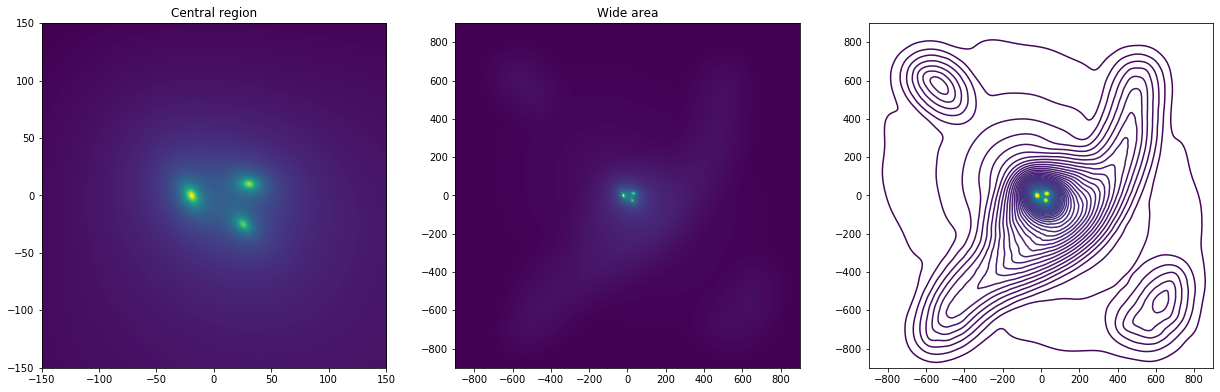

In [4]:
# Plot the lens, both for the central region and wider region
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
plotutil.plotDensity(liNarrow)
plt.gca().set_title("Central region")
plt.subplot(1,3,2)
plotutil.plotDensity(liWide)
plt.gca().set_title("Wide area")
plt.subplot(1,3,3)
plotutil.plotDensityContours(liWide, levels=np.arange(0, 15, 0.1))

In [5]:
# Create a number of points based on a grid layout
def createThetas(bottomLeft, topRight, numX, numY):
    thetas = np.empty([numY,numX,2], dtype=np.double)
    thetas[:,:,0], thetas[:,:,1] = np.meshgrid(np.linspace(bottomLeft[0], topRight[0], numX),
                                               np.linspace(bottomLeft[1], topRight[1], numY))
    return thetas

# Plot 'vectors', a list of 4-component lists: x pos, y pos, vector's x component and vector's y component
def plotVectors(vectors, angularScale=1, lengthFactor=1, **kwargs):
    
    xCoords, yCoords = [], []
    for cx, cy, vx, vy in vectors:
        length = (vx**2+vy**2)**0.5
        phi = np.arctan2(vy, vx)
        
        xCoords.append((cx/angularScale - length*lengthFactor*np.cos(phi)))
        xCoords.append((cx/angularScale + length*lengthFactor*np.cos(phi)))
        xCoords.append(None)
        yCoords.append((cy/angularScale - length*lengthFactor*np.sin(phi)))
        yCoords.append((cy/angularScale + length*lengthFactor*np.sin(phi)))
        yCoords.append(None)
        
    plt.plot(xCoords, yCoords, '-', **kwargs)
    plt.gca().set_xlim([vectors[:,0].min()/angularScale, vectors[:,0].max()/angularScale])
    plt.gca().set_ylim([vectors[:,1].min()/angularScale, vectors[:,1].max()/angularScale])

# Returns the shear components for the specified lens, at the specified positions
# shearType can be three things:
#  - "real": calculate the actual shear (typically called gamma) components
#  - "reduced": calculate the reduced shear (typically called g) components
#  - "averagedellipticity": calculate what the ellipticity components would be that a 
#    circular source has when its lensed position is theta, or equivalently what the
#    average ellipticity would be of many elliptical sources.
def getShearComponents(thetas, lens, zs, shearType):
    Dds = cosm.getAngularDiameterDistance(zd, zs)
    Ds = cosm.getAngularDiameterDistance(zs)
    
    thetas = thetas.reshape((-1,2))
    a = lens.getAlphaVectorDerivatives(thetas)
    a *= Dds/Ds
    axx, ayy, axy = a[:,0], a[:,1], a[:,2]
    kappa = 0.5*(axx+ayy)
    gamma1 = 0.5*(axx-ayy)
    gamma2 = axy
    
    if shearType == "real":
        return gamma1, gamma2
    
    if shearType == "realreduced":
        return gamma1/(1-kappa), gamma2/(1-kappa)
    
    if shearType == "averagedellipticity":
        g = (gamma1 + 1j*gamma2)/(1-kappa)
        flag = abs(g) > 1
        g[flag] = 1.0/g[flag].conjugate()
        return g.real, g.imag
    
    raise Exception("Invalid shearType")

# Plot shear/ellipticity at specified locations
def plotShearComponents(thetas, components, lengthFactor, angularScale=1, **kwargs):
    thetas = thetas.reshape((-1,2))
    g1 = components[0].reshape((-1,))
    g2 = components[1].reshape((-1,))
    g = (g1**2 + g2**2)**0.5
    angles = 0.5*np.arctan2(g2,g1)
    vx = g*np.cos(angles)
    vy = g*np.sin(angles)
    vectorField = np.empty((thetas.shape[0],4))
    vectorField[:,:2] = thetas
    vectorField[:,2] = vx
    vectorField[:,3] = vy
    plotVectors(vectorField, angularScale=angularScale, lengthFactor=lengthFactor, **kwargs)
    return vectorField

In [6]:
pointsXY = 24
thetasStrong = createThetas([-strongSize/2, -strongSize/2],[strongSize/2, strongSize/2], pointsXY, pointsXY)
thetasWeak = createThetas([-weakSize/2, -weakSize/2],[weakSize/2, weakSize/2], pointsXY, pointsXY)

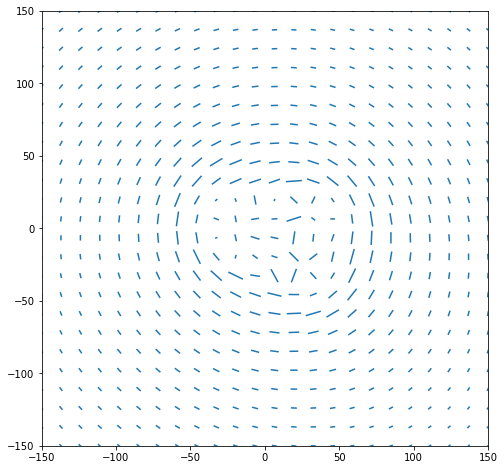

In [7]:
# Calculate and show the actual ellipticity field
lengthFactor = 5
plt.figure(figsize=(8,8))
components = getShearComponents(thetasStrong, lens, zs_1, shearType="averagedellipticity")
vAE = plotShearComponents(thetasStrong, components, lengthFactor, angularScale=ANGLE_ARCSEC)

In [8]:
# To illustrates that this field describes the transformation of circular sources,
# we'll generate a number of circular sources and show the lens effect
sources = [ ]
for pos in thetasStrong.reshape((-1,2)):
    sources.append(images.CircularSource(pos, 1.5*ANGLE_ARCSEC, fade=True))

Text(value='')

FloatProgress(value=0.0)

Text(value='')

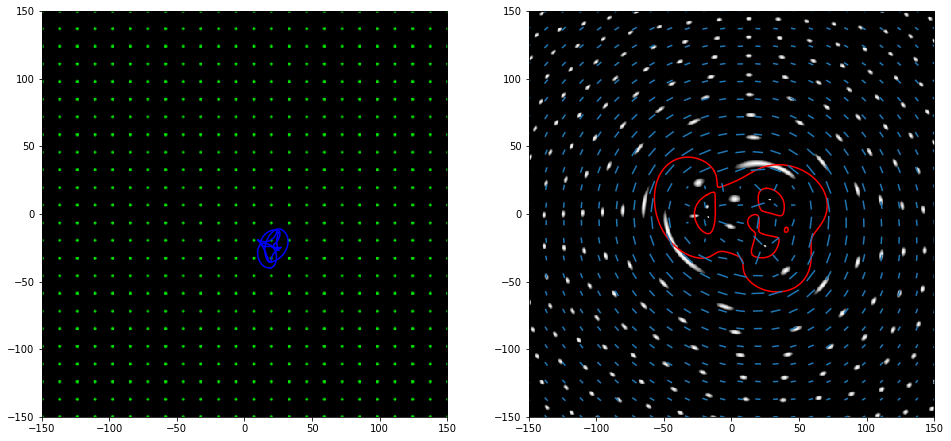

In [9]:
# Note that the sources are positioned on a regular grid in the source plane, and
# do not cause the images to lie on a regular grid. The ellipticity field on the
# other hand was calculate on a regular grid in the image plane.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plotutil.plotImagePlane(liNarrow, sources, plotImages=False, plotCriticalLines=False)
plt.subplot(1,2,2)
plotutil.plotImagePlane(liNarrow, sources, plotSources=False, plotCaustics=False)
plotVectors(vAE, angularScale=ANGLE_ARCSEC, lengthFactor=lengthFactor)

In [10]:
# To illustrate that the ellipticity field that was calculated describes the average
# ellipticity of an infinite amount of lensed elliptical galaxies shown at those points,
# here we'll calculate the average ellipticity of a finite number of such ellipticity
# measurements:
#  - we'll take a number of elliptical sources with random axis ratio, oriented along a
#    random direction
#  - assuming it is shown at 'theta', we'll calculate how this ellipticity is transformed
#  - after doing this for the requested number of sources, we'll average the ellipticities
def getEstimatedShearFromAveragedEllipses(lens, theta, zs, numAvg):
        
    frac = cosm.getAngularDiameterDistance(zd,zs)/cosm.getAngularDiameterDistance(zs)
    axx, ayy, axy = lens.getAlphaVectorDerivatives(theta)
    axx, ayy, axy = axx*frac, ayy*frac, axy*frac
    kappa = 0.5*(axx+ayy)
    gamma1 = 0.5*(axx-ayy)
    gamma2 = axy

    g1Ests = [ ]
    g2Ests = [ ]
    for i in range(numAvg):

        a_orig = 1
        b_orig = np.random.uniform(0.1,0.9) * a_orig
        theta_orig = np.random.uniform(0,2*np.pi)

        # see e.g. from https://arxiv.org/abs/astro-ph/0509252
        epsSrc = (1-b_orig/a_orig)/(1+b_orig/a_orig) * (np.cos(2*theta_orig) + 1j * np.sin(2*theta_orig))
        g = (gamma1 + 1j*gamma2)/(1-kappa)
        if abs(g) <= 1:
            epsImg = (epsSrc+g)/(1+g.conjugate()*epsSrc)
        else:
            epsImg = (1+g*epsSrc.conjugate())/(epsSrc.conjugate() + g.conjugate() )

        g1Est = epsImg.real
        g2Est = epsImg.imag

        g1Ests.append(g1Est)
        g2Ests.append(g2Est)

    return np.average(g1Ests), np.average(g2Ests)

In [11]:
# Here, we'll call the function above to create an estimate of the ellipticity
# field based on 25 measurements
numAvg = 25
componentsEllAvg = [ ]
for theta in thetasWeak.reshape((-1,2)):
    g1, g2 = getEstimatedShearFromAveragedEllipses(lens, theta, zs_1, numAvg)
    componentsEllAvg.append([g1,g2])

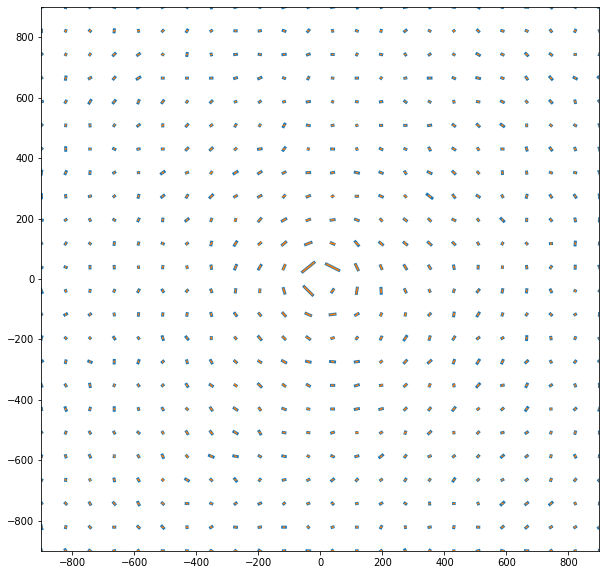

In [12]:
# And we'll plot both the real ellipticity field as well as the estimate from the 25
# sources. The latter is a more noisy version of the former.
plt.figure(figsize=(10,10))
plotShearComponents(thetasWeak, np.array(componentsEllAvg).T, 25, angularScale=ANGLE_ARCSEC, linewidth=3);

realEll = getShearComponents(thetasWeak, lens, zs=zs_1, shearType="averagedellipticity")
plotShearComponents(thetasWeak, realEll, 25, angularScale=ANGLE_ARCSEC);

In [13]:
# This function picks random source positions with redshifts as provided by
# the zsFunction helper function, lenses them, and calculates a random
# ellipticity that's transformed at that location (using the previous
# function, but wit numAvg=1)
def getRandomEllipticities(zsFunction, numTarget):

    thetas = [ ]
    zList = [ ]
    justReported = False

    while len(thetas) < numTarget:
        
        zs = zsFunction()
        
        liNarrow.setSourceRedshift(zs)
        liWide.setSourceRedshift(zs)
        zList.append(zs)

        beta = np.random.uniform(-15*ANGLE_ARCMIN, 15*ANGLE_ARCMIN, 2)
        if np.abs(beta).max() < 120*ANGLE_ARCSEC:
            li = liNarrow
        else:
            li = liWide

        ip = li.getImagePlane(feedbackObject="none")
        ts = ip.traceBeta(beta)
        for t in ts:
            if np.abs(t).max() < 15*ANGLE_ARCMIN:
                thetas.append(t)

        if len(thetas)%250 == 0:
            if not justReported:
                print(len(thetas))
                justReported = True
        else:
            justReported = False
                        
    components = []
    for theta,zs in zip(thetas,zList):
        g1, g2 = getEstimatedShearFromAveragedEllipses(lens, theta, zs, numAvg=1)
        components.append([g1,g2])
    
    return np.array(thetas), np.array(zList), components

In [14]:
# Call the function, where the redshift is chosen at random between 0.8 and 5, and
# collect 5000 fake ellipticity measurements this way. Note that the only uncertainty
# this way is the random orientation and ellipticity of the true source, all other
# observational issues are not taken into account.
zFunc = lambda: np.random.uniform(0.8, 5)
thetasEllRnd, zList, componentsEllRnd = getRandomEllipticities(zFunc, numTarget=5000)

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000


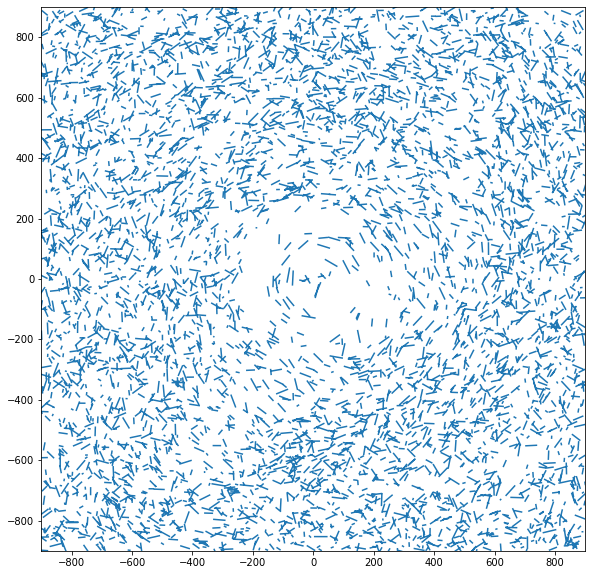

In [15]:
# Plot the fake measurements. You can also see how the strong lensing region
# has less measurements (due to the magnification equally spaced sources
# would lie further apart there)
plt.figure(figsize=(10,10))
plotShearComponents(thetasEllRnd, np.array(componentsEllRnd).T, 25, angularScale=ANGLE_ARCSEC);
plt.gca().set_aspect("equal")

In [16]:
# To illustrate the data, print the first ten fake measurements
print(f"#        X          Y         e1         e2 z")
for i in range(10):
    t, e, z = thetasEllRnd[i]/ANGLE_ARCSEC, componentsEllRnd[i], zList[i]
    print(f"{t[0]:10.4f} {t[1]:10.4f} {e[0]:10.4f} {e[1]:10.4f} {z}")

#        X          Y         e1         e2 z
   24.8552  -824.2723     0.0024     0.2955 1.7717122063063688
 -300.8676  -706.6589    -0.3161    -0.1483 1.1730559567152543
    5.8371  -446.6033    -0.2435     0.1070 4.392618413291762
  581.0119    51.3278    -0.2591     0.0871 3.107158901538149
 -743.9609   -33.8258     0.0703    -0.1075 4.389381656898139
 -195.4777  -635.7970    -0.0880    -0.0787 1.1402286300998605
  -85.1189   758.3144     0.0991     0.1585 1.713232457058982
  715.4126   235.1377     0.3342    -0.5897 1.132866741398422
 -507.5833   -50.4122    -0.1537     0.0252 1.344616661337282
  857.2150  -478.8777     0.4189     0.4552 4.611026175610213
